# EX_16  다음에 볼 영화 예측하기🎥

## 목표: Movielens 영화 SBR🎥

### lubric

1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행: 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행: 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰: 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.


### 🚩keyword

✔ Session-Based Recommendation: 세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천.
Session이란 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터, 서버 쪽에 저장.
유저의 행동 데이터들은 유저 측 브라우저를 통해 쿠키의 형태로 저장되는데 쿠키는 세션과 상호작용하면서 정보를 주고받는다.
이번 자료에서는 세션을 브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터와 같은 의미로 사용.

⚡고려해야 할 사항⚡

여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.
Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.
Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- SessionID 1회세션 포함 X  userID가 대신 역할 O
- time의 초 단위 시간 처리
- rating 데이터 처리

### Step 1. 데이터의 전처리

In [1]:
# 1 Data Load

import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import tensorflow
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/EXPLORATIONS/EX_16/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


⚡ 데이터 확인: 인덱스는 31,22,27,37,24 ~ 로 엉망진창/ Userid, Time순으로 배치되었기 때문

In [7]:
# 유저 수와 영화 수, 시간 수 확인

print('Unique 한 유저의 수는', data['UserId'].nunique(), '개 입니다!')
print('Unique 한 영화의 수는', data['ItemId'].nunique(), '개 입니다!')
print('Unique 한 시간의 수는', data['Time'].nunique(), '개 입니다!')

Unique 한 유저의 수는 6039 개 입니다!
Unique 한 영화의 수는 3628 개 입니다!
Unique 한 시간의 수는 412911 개 입니다!


항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의.

#### 1) Session ID 정의

In [8]:
# UserId와 Time을 기준으로 새로운 데이터프레임 생성
df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
df.reset_index(inplace=True)
df

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
423403,423403,6040,997454398,1
423404,423404,6040,997454429,1
423405,423405,6040,997454464,2
423406,423406,6040,997454486,1


In [9]:
# SessionId 컬럼 추가
data = pd.merge(data, df, on=['UserId', 'Time'])
data.drop(columns='ItemId_y', inplace=True)
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
836473,6040,2917,4,997454429,423404
836474,6040,1921,4,997454464,423405
836475,6040,1784,3,997454464,423405
836476,6040,161,3,997454486,423406


In [10]:
# 2 Session Length

session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
423403    1
423404    1
423405    2
423406    1
423407    1
Length: 423408, dtype: int64

여기서 session_length란 같은 SessionId를 공유하는 데이터 row의 개수를 의미. 여기서 SessionId란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자. 로그인하지 않았기 때문에 이 사용자가 누군지는 알 수 없어도, 최소한 특정 사용자의 행동을 SessionId 기준으로 모아서 분류는 가능. 따라서 여기서 session_length란 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지(몇 개의 상품정보를 클릭했는지)의 의미.

길이의 중앙값(median) 과 평균(mean) 

In [11]:
session_length.median(), session_length.mean()

(1.0, 1.9755838340324225)

길이의 최솟값(min) 과 최댓값(max)

In [12]:
session_length.min(), session_length.max()

(1, 28)

모든 세션에서 최소 하나의 영화에 평점을 남겼으며, 많게는 30편의 영화에 평점을 남긴 세션도 있다.

In [13]:
session_length.quantile(0.999)

10.0

In [14]:
## 95%, 99%, 99.9%, 99.99%

print('전체의 95% 정도는', session_length.quantile(0.95), '개의 영화에 평점을 남겼습니다.')         
print('전체의 99% 정도는', session_length.quantile(0.99), '개의 영화에 평점을 남겼습니다.')         
print('전체의 99.9% 정도는', session_length.quantile(0.999), '개의 영화에 평점을 남겼습니다.')      
print('전체의 99.99% 정도는', session_length.quantile(0.9999), '개의 영화에 평점을 남겼습니다.')    

전체의 95% 정도는 5.0 개의 영화에 평점을 남겼습니다.
전체의 99% 정도는 7.0 개의 영화에 평점을 남겼습니다.
전체의 99.9% 정도는 10.0 개의 영화에 평점을 남겼습니다.
전체의 99.99% 정도는 17.0 개의 영화에 평점을 남겼습니다.


In [16]:
# 분포 누적합

length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.514338
2    0.751370
3    0.876445
4    0.938879
5    0.970388
6    0.986186
7    0.993720
8    0.997112
9    0.998682
dtype: float64

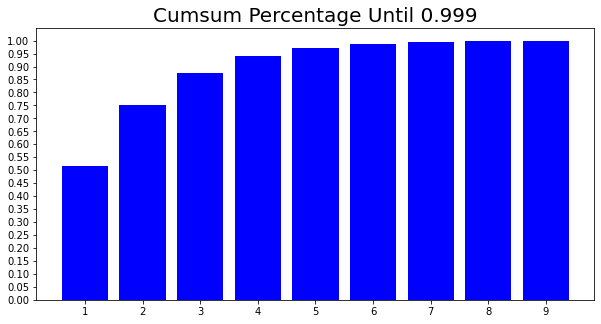

In [17]:
# 전체 분포 누적합 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='blue')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

Q) 추천 시스템에서 다루는 시간 관련 데이터는 다양한 측면이 있습니다. 데이터 생성 날짜 말고 또 어떤 요소가 있을까요?

접속하는 시간대(오전, 오후, 새벽), 접속해 있는 시간, 접속하는 요일, 계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등등

#### 2) 초단위 시간 처리

In [18]:
# 3 Session Time

oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [33]:
data['Time'] = data['Time'].apply(lambda x: dt.datetime.utcfromtimestamp(x))
data

,SessionId,UserId,Time,ItemId,Rating
0,0,1,2000-12-31 22:00:19,3186,4
1,1,1,2000-12-31 22:00:55,1270,5
2,1,1,2000-12-31 22:00:55,1721,4
3,1,1,2000-12-31 22:00:55,1022,5
4,2,1,2000-12-31 22:01:43,2340,3
...,...,...,...,...,...
836473,423404,6040,2001-08-10 14:40:29,2917,4
836474,423405,6040,2001-08-10 14:41:04,1921,4
836475,423405,6040,2001-08-10 14:41:04,1784,3
836476,423406,6040,2001-08-10 14:41:26,161,3


In [34]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [35]:
year_ago = latest - dt.timedelta(365)
print(len(data[data['Time'] > year_ago]))

17567


In [36]:
twoyears_ago = latest - dt.timedelta(365*2)
print(len(data[data['Time'] > twoyears_ago]))

56922


In [37]:
data = data[['SessionId', 'UserId', 'Time', 'ItemId', 'Rating']]
data

,SessionId,UserId,Time,ItemId,Rating
0,0,1,2000-12-31 22:00:19,3186,4
1,1,1,2000-12-31 22:00:55,1270,5
2,1,1,2000-12-31 22:00:55,1721,4
3,1,1,2000-12-31 22:00:55,1022,5
4,2,1,2000-12-31 22:01:43,2340,3
...,...,...,...,...,...
836473,423404,6040,2001-08-10 14:40:29,2917,4
836474,423405,6040,2001-08-10 14:41:04,1921,4
836475,423405,6040,2001-08-10 14:41:04,1784,3
836476,423406,6040,2001-08-10 14:41:26,161,3


#### 3) Rating이 낮은 데이터 처리

In [38]:
print('유저가 준 평점의 최솟값은', data['Rating'].min(), '점입니다.')
print('유저가 준 평점의 최댓값은', data['Rating'].max(), '점입니다.')

유저가 준 평점의 최솟값은 3 점입니다.
유저가 준 평점의 최댓값은 5 점입니다.


In [39]:
print(len(data[data['Rating'] >= 1]))   # 평점의 최솟값이 1이므로 Entire Data의 개수가 나온다.
print(len(data[data['Rating'] >= 2]))   # 평점이 2점 이상인 데이터의 총 개수
print(len(data[data['Rating'] >= 3]))   # 평점이 3점 이상인 데이터의 총 개수
print(len(data[data['Rating'] >= 4]))   # 평점이 4점 이상인 데이터의 총 개수
print(len(data[data['Rating'] >= 5]))   # 평점의 최댓값을 준 데이터의 개수이다.

836478
836478
836478
575281
226310


In [40]:
data = data[data['Rating'] >= 3]
data = data[['SessionId', 'UserId', 'Time', 'ItemId', 'Rating']]
data

,SessionId,UserId,Time,ItemId,Rating
0,0,1,2000-12-31 22:00:19,3186,4
1,1,1,2000-12-31 22:00:55,1270,5
2,1,1,2000-12-31 22:00:55,1721,4
3,1,1,2000-12-31 22:00:55,1022,5
4,2,1,2000-12-31 22:01:43,2340,3
...,...,...,...,...,...
836473,423404,6040,2001-08-10 14:40:29,2917,4
836474,423405,6040,2001-08-10 14:41:04,1921,4
836475,423405,6040,2001-08-10 14:41:04,1784,3
836476,423406,6040,2001-08-10 14:41:26,161,3


In [41]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [42]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [43]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [44]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 819375
	 Sessions: 411077
	 Items: 3618
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:14:13

* valid Set Stats Info
	 Events: 9795
	 Sessions: 7014
	 Items: 2372
	 First Time : 2002-03-05 04:24:20
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 7298
	 Sessions: 5308
	 Items: 2064
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [45]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [46]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step 2. 미니 배치의 구성

Session-Parallel Mini-Batch 구현

In [47]:
# 1 SessionDataset

class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보기.
click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있고 session_idx 변수는 각 세션을 인덱싱한 np.array

In [48]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,UserId,Time,ItemId,Rating,item_idx
0,0,1,2000-12-31 22:00:19,3186,4,0
1,1,1,2000-12-31 22:00:55,1270,5,1
2,1,1,2000-12-31 22:00:55,1721,4,2
3,1,1,2000-12-31 22:00:55,1022,5,3
4,2,1,2000-12-31 22:01:43,2340,3,4
5,3,1,2000-12-31 22:02:52,1836,5,5
6,4,1,2000-12-31 22:04:35,3408,4,6
7,5,1,2000-12-31 22:11:59,2804,5,7
8,5,1,2000-12-31 22:11:59,1207,4,8
9,6,1,2000-12-31 22:12:40,1193,5,9


In [49]:
##click_offsets - 각 세션이 시작된 index를 담고 있다.

tr_dataset.click_offsets

array([     0,      1,      4, ..., 819373, 819374, 819375], dtype=int32)

In [50]:
# session_idx - 각 세션을 indexing한 Numpy Array이다.

tr_dataset.session_idx

array([     0,      1,      2, ..., 411074, 411075, 411076])

In [51]:
# 2 SessionDataLoader

# SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
# __iter__ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.
# mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [52]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,UserId,Time,ItemId,Rating,item_idx
0,0,1,2000-12-31 22:00:19,3186,4,0
1,1,1,2000-12-31 22:00:55,1270,5,1
2,1,1,2000-12-31 22:00:55,1721,4,2
3,1,1,2000-12-31 22:00:55,1022,5,3
4,2,1,2000-12-31 22:01:43,2340,3,4
5,3,1,2000-12-31 22:02:52,1836,5,5
6,4,1,2000-12-31 22:04:35,3408,4,6
7,5,1,2000-12-31 22:11:59,2804,5,7
8,5,1,2000-12-31 22:11:59,1207,4,8
9,6,1,2000-12-31 22:12:40,1193,5,9


In [53]:
iter_ex = iter(tr_data_loader)

In [54]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


In [55]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [21  2 26 10]
Label Item Idx are :       [22  3 27 11]
Previous Masked Input Idx are [2]


In [56]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [22 28 37 35]
Label Item Idx are :       [23 29 38 36]
Previous Masked Input Idx are [2]


### Step 3. 모델 구성

모델 성능에 대한 지표: recall@k, MRR
<br>
Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋다.
이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용한다.
추천에서는 몇 번째로 맞추느냐도 중요하다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것이므로. 따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용.
MRR은 정답 아이템이 나온 순번의 역수 값.
따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안 나온다면 지표가 낮아질 것.

In [57]:
# 1 Evaluation Metric

def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [58]:
# 2 Model Architecture

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

print('nice!')

nice!


In [59]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [60]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [61]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 3618)]         0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  550500    
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 3618)              184518    
Total params: 735,018
Trainable params: 735,018
Non-trainable params: 0
_________________________________________________________________


In [62]:
# 3 Model Training

# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [63]:
train_model(model, args)

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]


	 - Recall@20 epoch 1: nan
	 - MRR@20    epoch 1: nan



Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]


	 - Recall@20 epoch 2: nan
	 - MRR@20    epoch 2: nan



Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

	 - Recall@20 epoch 3: nan
	 - MRR@20    epoch 3: nan



### Step 4. 모델 학습

In [ ]:
# 학습된 모델을 불러옵니다.
model = tf.keras.models.load_model(data_path / 'trained_model')

In [67]:
# Inference

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 0it [00:00, ?it/s]

	 - Recall@20: nan
	 - MRR@20: nan



### Step 5. 모델 테스트

* 처음 시도

* 두 번째 시도


In [64]:
# 1) batch_size 128 → 256 변경

args1 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

model1 = create_model(args1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3618)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    550500    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3618)               184518    
Total params: 735,018
Trainable params: 735,018
Non-trainable params: 0
_________________________________________________________________


In [65]:
train_model(model1, args1)

Evaluation:  90%|█████████ | 9/10 [00:12<00:01,  1.43s/it]


	 - Recall@20 epoch 1: 0.078125
	 - MRR@20    epoch 1: 0.021764



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.27s/it]


	 - Recall@20 epoch 2: 0.159288
	 - MRR@20    epoch 2: 0.052076



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.25s/it]


	 - Recall@20 epoch 3: 0.205295
	 - MRR@20    epoch 3: 0.066849



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.29s/it]


	 - Recall@20 epoch 4: 0.226562
	 - MRR@20    epoch 4: 0.073719



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.26s/it]


	 - Recall@20 epoch 5: 0.233941
	 - MRR@20    epoch 5: 0.079072



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.25s/it]


	 - Recall@20 epoch 6: 0.236979
	 - MRR@20    epoch 6: 0.082206



Evaluation:  90%|█████████ | 9/10 [00:10<00:01,  1.20s/it]


	 - Recall@20 epoch 7: 0.235677
	 - MRR@20    epoch 7: 0.084780



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.23s/it]


	 - Recall@20 epoch 8: 0.241753
	 - MRR@20    epoch 8: 0.085866



Evaluation:  90%|█████████ | 9/10 [00:10<00:01,  1.21s/it]


	 - Recall@20 epoch 9: 0.242188
	 - MRR@20    epoch 9: 0.086745



Evaluation:  90%|█████████ | 9/10 [00:11<00:01,  1.25s/it]

	 - Recall@20 epoch 10: 0.241753
	 - MRR@20    epoch 10: 0.087053



In [68]:
test_model(model1, args1, test)

Evaluation:  86%|████████▌ | 6/7 [00:07<00:01,  1.21s/it]

	 - Recall@20: 0.220052
	 - MRR@20: 0.085350



In [69]:
# 2) batch_size 다시 128 고정, dropout 비율 0.1 → 0.2

args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=20)

model2 = create_model(args2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3618)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    550500    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3618)               184518    
Total params: 735,018
Trainable params: 735,018
Non-trainable params: 0
_________________________________________________________________


In [70]:
train_model(model2, args2)

Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.44it/s]


	 - Recall@20 epoch 1: 0.111328
	 - MRR@20    epoch 1: 0.031819



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.53it/s]


	 - Recall@20 epoch 2: 0.191797
	 - MRR@20    epoch 2: 0.063911



Evaluation:  95%|█████████▌| 20/21 [00:13<00:00,  1.50it/s]


	 - Recall@20 epoch 3: 0.225000
	 - MRR@20    epoch 3: 0.075502



Evaluation:  95%|█████████▌| 20/21 [00:12<00:00,  1.55it/s]


	 - Recall@20 epoch 4: 0.236719
	 - MRR@20    epoch 4: 0.081336



Evaluation:  95%|█████████▌| 20/21 [00:12<00:00,  1.59it/s]


	 - Recall@20 epoch 5: 0.243359
	 - MRR@20    epoch 5: 0.086206



Evaluation:  95%|█████████▌| 20/21 [00:12<00:00,  1.56it/s]


	 - Recall@20 epoch 6: 0.245703
	 - MRR@20    epoch 6: 0.087086



Evaluation:  95%|█████████▌| 20/21 [00:12<00:00,  1.61it/s]


	 - Recall@20 epoch 7: 0.248047
	 - MRR@20    epoch 7: 0.085485



Evaluation:  95%|█████████▌| 20/21 [00:12<00:00,  1.56it/s]


	 - Recall@20 epoch 8: 0.243359
	 - MRR@20    epoch 8: 0.085403



Evaluation:  95%|█████████▌| 20/21 [00:12<00:00,  1.58it/s]


	 - Recall@20 epoch 9: 0.248438
	 - MRR@20    epoch 9: 0.085114



Evaluation:  95%|█████████▌| 20/21 [00:12<00:00,  1.57it/s]

	 - Recall@20 epoch 10: 0.250391
	 - MRR@20    epoch 10: 0.085614



In [71]:
test_model(model2, args2, test)

Evaluation:  93%|█████████▎| 14/15 [00:08<00:00,  1.57it/s]

	 - Recall@20: 0.241629
	 - MRR@20: 0.082050



### Trial and error


1) batch_size 128 → 256 변경(batch_size : 128, hsz : 50, Dropout : 0.1)

Evaluation:  86%|████████▌ | 6/7 [00:07<00:01,  1.21s/it]
- Recall@20: 0.220052
- MRR@20: 0.085350
    
2) batch_size 다시 128 고정, dropout 비율 0.1 → 0.2(batch_size : 256, hsz : 50, Dropout : 0.1)

Evaluation:  93%|█████████▎| 14/15 [00:08<00:00,  1.57it/s]
- Recall@20: 0.241629
- MRR@20: 0.082050

시작 하기도 전부터 말이 많았던 노드였다. 추천시스템에 대해 더 알아보고 싶었는데 데이터셋이 잘못된 점, 처음부터 training을 시키지 않고 진행하는 점 등등 개인별 실력에 대해 많이 의존한 느낌이었다. 도움을 많이 받고 진행한 결과 어느정도 의미있는 지표도 뽑고 초반 전처리 과정이 재밌어 끝내긴 했다만 아쉬움이 많이 남는다. 나중에 기회가 된다면 꼭 다시 공부하고 싶은 부분이다. 